
<br>
<h5><b>Import libraries and loading data</b></h5>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings(action='ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.formula.api as formula
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels as sm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error,median_absolute_error,mean_absolute_percentage_error,mean_squared_log_error,explained_variance_score
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from IPython.display import display
import matplotlib.pyplot as plt

In [ ]:
# get the name of the csv file
file ='https://raw.githubusercontent.com/prince381/air-pollution/master/data/PRSA_Data_Wanshouxigong_20130301-20170228.csv'


# read the csv file into a pandas DataFrame using the pd.read_csv()
data = pd.read_csv(file)
data.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,9.0,9.0,6.0,17.0,200.0,62.0,0.3,1021.9,-19.0,0.0,WNW,2.0,Wanshouxigong
1,2,2013,3,1,1,11.0,11.0,7.0,14.0,200.0,66.0,-0.1,1022.4,-19.3,0.0,WNW,4.4,Wanshouxigong
2,3,2013,3,1,2,8.0,8.0,NaN,16.0,200.0,59.0,-0.6,1022.6,-19.7,0.0,WNW,4.7,Wanshouxigong
3,4,2013,3,1,3,8.0,8.0,3.0,16.0,NaN,NaN,-0.7,1023.5,-20.9,0.0,NW,2.6,Wanshouxigong
4,5,2013,3,1,4,8.0,8.0,3.0,NaN,300.0,36.0,-0.9,1024.1,-21.7,0.0,WNW,2.5,Wanshouxigong


<h3><b>Data Preprocessing</b></h3>

In [ ]:
# drop the unwanted columns/features
cols_to_drop = ['No','station']
data = data.drop(cols_to_drop,axis=1)
# print out the info of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    35064 non-null  int64  
 1   month   35064 non-null  int64  
 2   day     35064 non-null  int64  
 3   hour    35064 non-null  int64  
 4   PM2.5   34368 non-null  float64
 5   PM10    34580 non-null  float64
 6   SO2     34395 non-null  float64
 7   NO2     34310 non-null  float64
 8   CO      33767 non-null  float64
 9   O3      33986 non-null  float64
 10  TEMP    35045 non-null  float64
 11  PRES    35045 non-null  float64
 12  DEWP    35045 non-null  float64
 13  RAIN    35045 non-null  float64
 14  wd      34985 non-null  object 
 15  WSPM    35051 non-null  float64
dtypes: float64(11), int64(4), object(1)
memory usage: 4.3+ MB


In [ ]:
# check for duplicated values and null values
print('Are there any duplicated values in our data ? : {}\n'.format(data.duplicated().any()))
print('The total number of null values in each colum:')
display(data.isnull().sum())

Are there any duplicated values in our data ? : False

The total number of null values in each colum:


year        0
month       0
day         0
hour        0
PM2.5     696
PM10      484
SO2       669
NO2       754
CO       1297
O3       1078
TEMP       19
PRES       19
DEWP       19
RAIN       19
wd         79
WSPM       13
dtype: int64

In [ ]:
# find the most appearing wind direction value
data.wd.mode()

0    NE
Name: wd, dtype: object

In [ ]:
# fill in the missing values with the mean of the particular column
data.fillna(value=data.mean(),inplace=True)
# replace the missing values for the wind direction with the modal value
data.wd.fillna(value='NE',inplace=True)
# let's check the data again if there are any missing values
data.isnull().any()

year     False
month    False
day      False
hour     False
PM2.5    False
PM10     False
SO2      False
NO2      False
CO       False
O3       False
TEMP     False
PRES     False
DEWP     False
RAIN     False
wd       False
WSPM     False
dtype: bool

In [ ]:
# create a datetime column using the year,month,day and hour columns.
years = data['year'].values
months = data['month'].values
days = data['day'].values
hours = data['hour'].values
full_date = []

for i in range(data.shape[0]):
    date_time = str(years[i])+'-'+str(months[i])+'-'+str(days[i])+' '+str(hours[i])+':'+str(0)
    full_date.append(date_time)

dates = pd.to_datetime(full_date)
dates = pd.DataFrame(dates,columns=['date'])
data = pd.concat([dates,data],axis=1)

data.head()

,date,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM
0,2013-03-01 00:00:00,2013,3,1,0,9.0,9.0,6.000000,17.00000,200.000000,62.000000,0.3,1021.9,-19.0,0.0,WNW,2.0
1,2013-03-01 01:00:00,2013,3,1,1,11.0,11.0,7.000000,14.00000,200.000000,66.000000,-0.1,1022.4,-19.3,0.0,WNW,4.4
2,2013-03-01 02:00:00,2013,3,1,2,8.0,8.0,17.148603,16.00000,200.000000,59.000000,-0.6,1022.6,-19.7,0.0,WNW,4.7
3,2013-03-01 03:00:00,2013,3,1,3,8.0,8.0,3.000000,16.00000,1370.395031,56.229904,-0.7,1023.5,-20.9,0.0,NW,2.6
4,2013-03-01 04:00:00,2013,3,1,4,8.0,8.0,3.000000,55.52956,300.000000,36.000000,-0.9,1024.1,-21.7,0.0,WNW,2.5


 EXPLORATORY DATA ANALYSIS

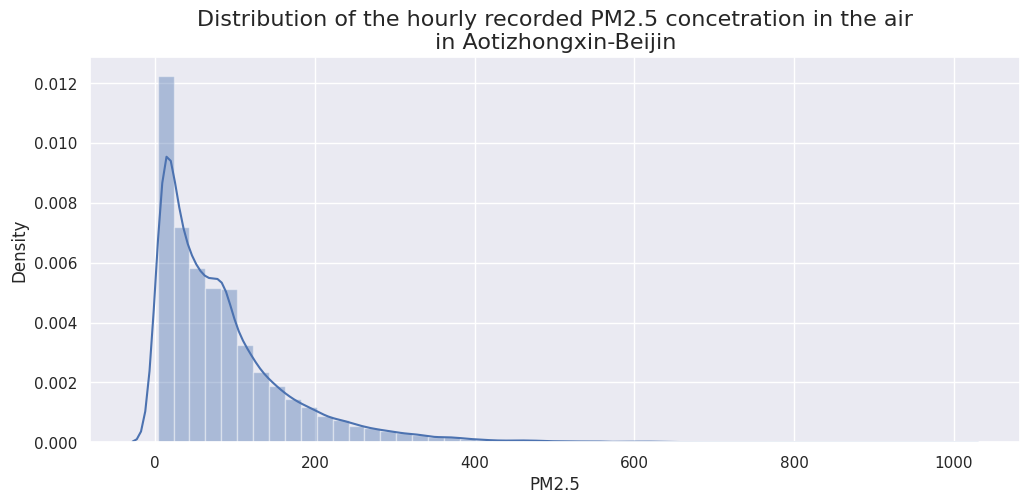

In [ ]:
plt.figure(figsize=(12,5))
sns.distplot(data['PM2.5'],bins=50)
plt.title('Distribution of the hourly recorded PM2.5 concetration in the air\nin Aotizhongxin-Beijin',
          fontsize=16)
plt.show()

<h5><b>what pattern does the amount of PM2.5 concentration in the air recorded in an hour follow
        for a daily time period ?</b></h5>

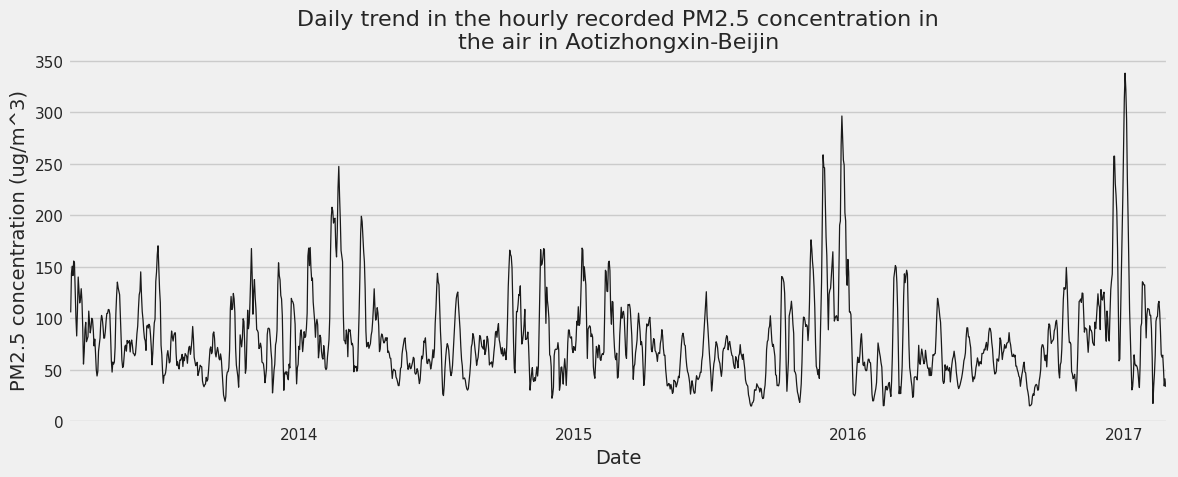

In [ ]:
# find the daily average of PM2.5 contained in the air in any given hour
daily_data = data[['date','PM2.5']]
daily_data = daily_data.set_index('date')
daily_data = daily_data.resample('D').median()
decomposition = seasonal_decompose(daily_data,model='addictive')

# plot the data
with plt.style.context('fivethirtyeight'):
    decomposition.trend.plot(figsize=(12,5),style='k-',linewidth=.9,legend=False)
    plt.xlabel('Date',fontsize=14)
    plt.ylabel('PM2.5 concentration (ug/m^3)',fontsize=14)
    plt.title('Daily trend in the hourly recorded PM2.5 concentration in\nthe air in Aotizhongxin-Beijin',fontsize=16)
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

<h5><b>In which month does the amount of PM2.5 contained in the air rises ?</b></h5>

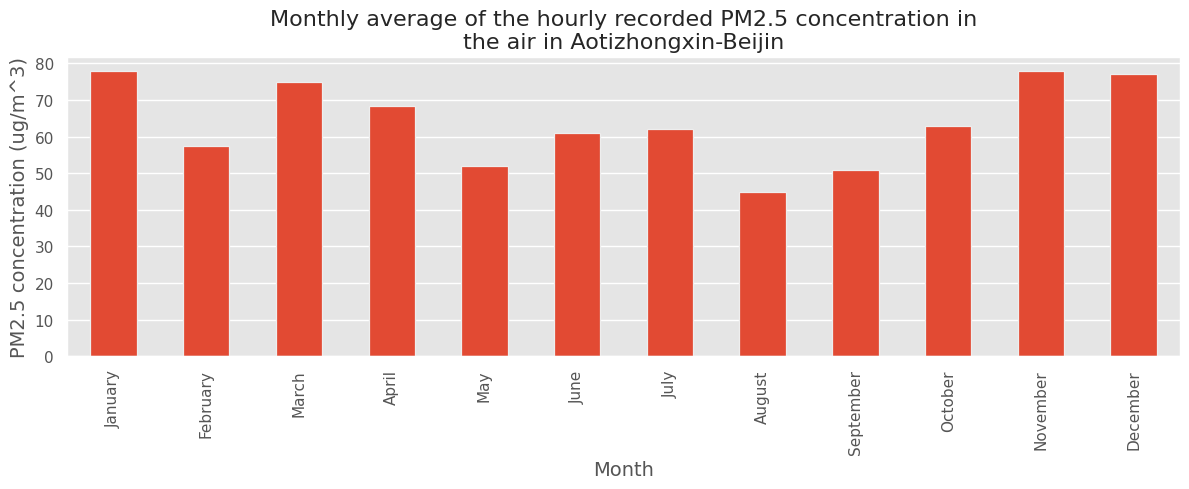

In [ ]:
monthly_data = data[['month','PM2.5']]
months = ['January','February','March','April','May','June','July',
         'August','September','October','November','December']
ordered_monthdf = pd.DataFrame(months,columns=['month'])
map_dict = {}
for i,j in enumerate(months):
    map_dict.setdefault(i+1,j)

monthly_data.month = monthly_data.month.map(map_dict)
monthly_average = monthly_data.groupby('month').median()
monthly_average = pd.merge(ordered_monthdf,monthly_average,left_on='month',right_index=True)
monthly_average = np.round(monthly_average,1)
monthly_average = monthly_average.set_index('month')

# plot the data
with plt.style.context('ggplot'):
    monthly_average.plot(figsize=(12,5),legend=False,kind='bar',linewidth=.9)
    plt.xlabel('Month',fontsize=14)
    plt.ylabel('PM2.5 concentration (ug/m^3)',fontsize=14)
    plt.title('Monthly average of the hourly recorded PM2.5 concentration in\nthe air in Aotizhongxin-Beijin',fontsize=16)
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

<h5><b>At what time of the day do we expect the amount of PM2.5 concentration in the air to be high ?</b></h5>

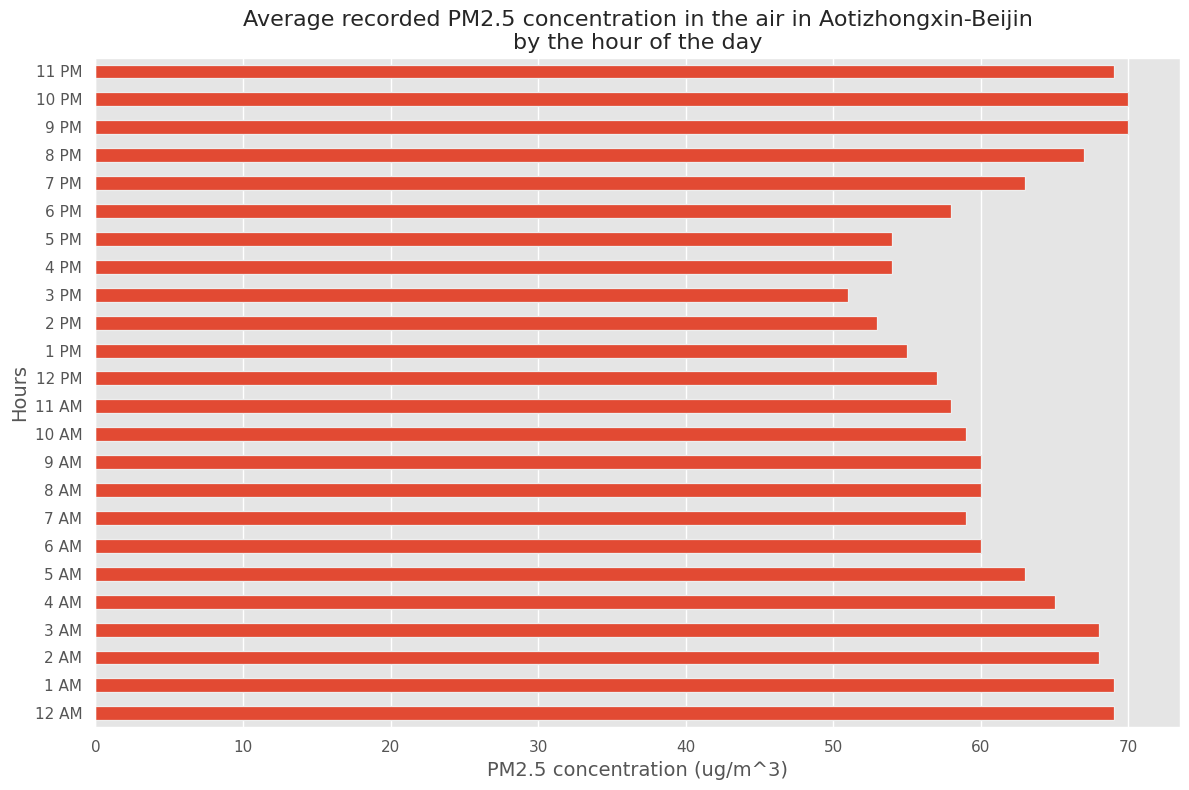

In [ ]:
hourly_data = data[['hour','PM2.5']]
hrs = ['12 AM','1 AM','2 AM','3 AM','4 AM','5 AM','6 AM','7 AM','8 AM','9 AM','10 AM',
      '11 AM','12 PM','1 PM','2 PM','3 PM','4 PM','5 PM','6 PM','7 PM',
      '8 PM','9 PM','10 PM','11 PM']
hour_dict = {}
for i,j in enumerate(hrs):
    hour_dict.setdefault(i,j)

hourly_data = hourly_data.groupby('hour').median().reset_index()
hourly_data.hour = hourly_data.hour.map(hour_dict)
hourly_data = hourly_data.set_index('hour')

# plot the data
with plt.style.context('ggplot'):
    hourly_data.plot(figsize=(12,8),legend=False,kind='barh',linewidth=.9)
    plt.ylabel('Hours',fontsize=14)
    plt.xlabel('PM2.5 concentration (ug/m^3)',fontsize=14)
    plt.title('Average recorded PM2.5 concentration in the air in Aotizhongxin-Beijin\nby the hour of the day',fontsize=16)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

<h5><b>In which direction does polluted air/wind mostly move ?</b></h5>

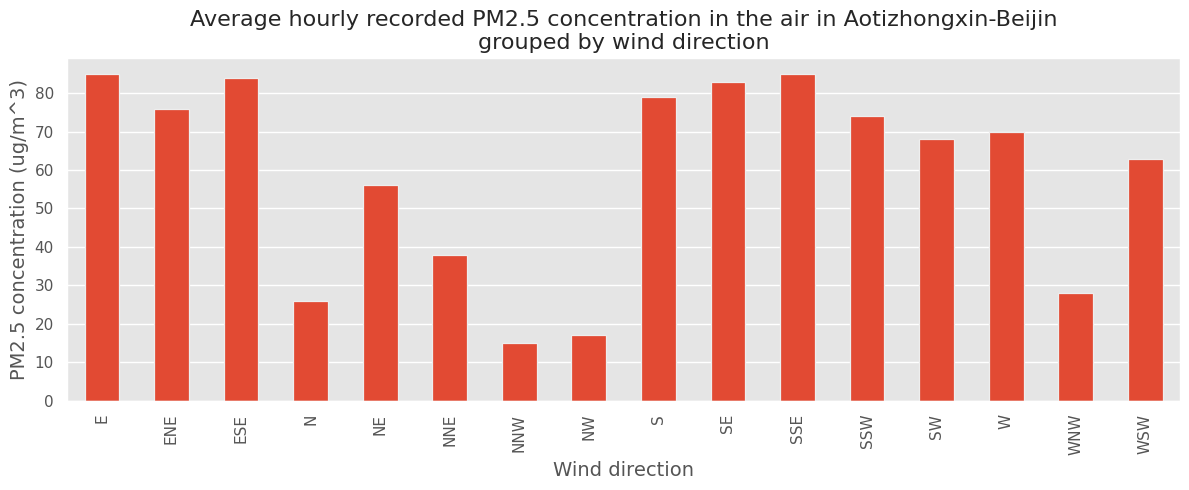

In [ ]:
wind_dir = data[['wd','PM2.5']]
wind_dir = wind_dir.groupby('wd').median()

# plot the data
with plt.style.context('ggplot'):
    wind_dir.plot(figsize=(12,5),legend=False,kind='bar',linewidth=.9)
    plt.xlabel('Wind direction',fontsize=14)
    plt.ylabel('PM2.5 concentration (ug/m^3)',fontsize=14)
    plt.title('Average hourly recorded PM2.5 concentration in the air in Aotizhongxin-Beijin\ngrouped by wind direction',fontsize=16)
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

<h5><b>How do the other environmental factors affect the amount of PM2.5 concentration in the air ?</b></h5>

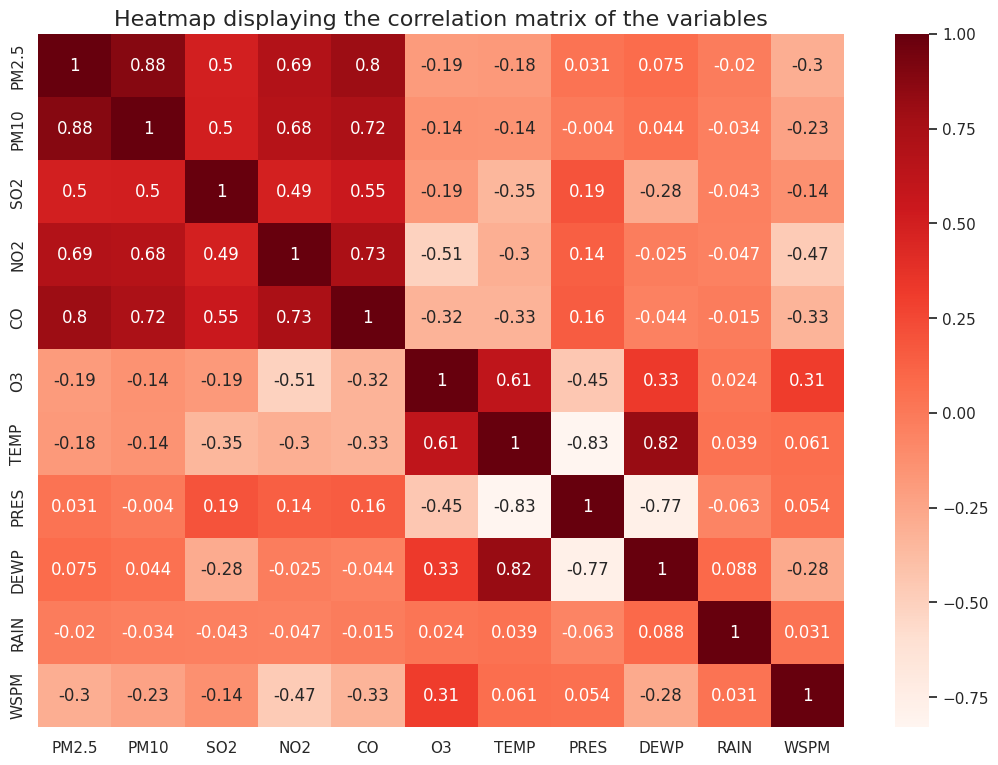

In [ ]:
# let's try and visualize the relationships between the features of the data
plt.figure(figsize=(13,9))
correlation_data = data[['PM2.5', 'PM10', 'SO2', 'NO2',
                         'CO', 'O3', 'TEMP', 'PRES',
                         'DEWP', 'RAIN', 'WSPM']]
sns.heatmap(correlation_data.corr(),cmap=plt.cm.Reds,annot=True)
plt.title('Heatmap displaying the correlation matrix of the variables',fontsize=16)
plt.show()

<h3><b>Model Training and Evaluation</b></h3>
<br>
<h5><b>check for multicollinearity among variables and fit a regression model using statsmodels</b></h5>

In [ ]:
cols_to_drop = ['date','year','month','day','hour','wd']
newdata = data.drop(cols_to_drop,axis=1)

# calculate the variance inflation factor of each feature and detect multicollinearity
cons_data = sm.tools.add_constant(newdata)
series_before = pd.Series([variance_inflation_factor(cons_data.values,i) for i in range(cons_data.shape[1])],
                         index=cons_data.columns)
series_before

const    33973.892623
PM2.5        6.310678
PM10         5.134457
SO2          1.778971
NO2          3.721461
CO           3.754783
O3           2.458104
TEMP         8.498873
PRES         3.636785
DEWP         6.113427
RAIN         1.027840
WSPM         1.735738
dtype: float64

In [ ]:
# we can see that TEMP (temperature) and DEWP (dewpoint) are highly correlated as the VIF value is
# greater than 5. As a result, we get rid of one of those features and probably the one that has the
# lowest correlation with the dependent variable.
newdata = newdata.drop('DEWP',axis=1)
cons_data2 = sm.tools.add_constant(newdata)
series_after = pd.Series([variance_inflation_factor(cons_data2.values,i) for i in range(cons_data2.shape[1])],
                         index=cons_data2.columns)
series_after

const    32691.396274
PM2.5        6.015357
PM10         5.081732
SO2          1.654661
NO2          3.700240
CO           3.652982
O3           2.353586
TEMP         4.750099
PRES         3.490109
RAIN         1.010724
WSPM         1.386035
dtype: float64

In [ ]:
newdata.columns = ['PM2_5','PM10','SO2','NO2','CO','O3','TEMP','PRES','RAIN','WSPM']

# PM2.5 is skewed to the right so we log transform the values to normalize the distribution
newdata['PM2_5'] = np.log(newdata['PM2_5'])

In [ ]:
# fit the regression model
mul_reg = formula.ols(formula='PM2_5 ~ PM10 + SO2 + NO2 + CO + O3 + TEMP + PRES + RAIN + WSPM',
                      data=newdata).fit()
mul_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  PM2_5   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     7998.
Date:                Sat, 06 May 2023   Prob (F-statistic):               0.00
Time:                        03:37:12   Log-Likelihood:                -34567.
No. Observations:               35064   AIC:                         6.915e+04
Df Residuals:                   35054   BIC:                         6.924e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.1941      0.626     14.681      0.000       7.967      10.422
PM10           0.0053   5.86e-05     89.612      0.000       0.005       0.005
SO2            0.0032      0.000     16.828      0.000       0.003       0.004
NO2            0.0058      0.000     30.866      0.000       0.005       0.006
CO             0.0002   5.03e-06     35.669      0.000       0.000       0.000
O3             0.0015   9.45e-05     15.874      0.000       0.001       0.002
TEMP           0.0085      0.001     12.766      0.000       0.007       0.010
PRES          -0.0064      0.001    -10.384      0.000      -0.008      -0.005
RAIN           0.0268      0.004      6.130      0.000       0.018       0.035
WSPM          -0.1471      0.003    -43.644      0.000      -0.154      -0.141
==============================================================================
Omnibus:                     5609.995   Durbin-Watson:                   0.414
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11179.397
Skew:                          -0.981   Prob(JB):                         0.00
Kurtosis:                       4.949   Cond. No.                     3.61e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.61e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<p>The OLS model from statsmodels gives us an accuracy of 71% (0.712) which is not satisfactory for prediction. So we move on to fit a linear regression model from the scikit-learn library.</p>
<br>
<h5><b>fitting a linear regression model with sklearn.linear_model.LinearRegression()</b></h5>

In [ ]:
# we split the data into predictor variables and Outcome variable
X = newdata.drop('PM2_5',axis=1)
y = newdata['PM2_5']

# we need to scale or normalize the predictor variables since they are not on the same
# scale and some of their distributions are skewed.
X_scaled =  preprocessing.scale(X)
X_scaled = pd.DataFrame(X_scaled,columns=X.columns)
X_scaled.dropna(inplace=True)
# print the scaled predictor variables.
X_scaled.head()

,PM10,SO2,NO2,CO,O3,TEMP,PRES,RAIN,WSPM
0,-1.065083,-0.470187,-1.087778,-9.750964e-01,0.102675,-1.184729,0.982994,-0.080728,0.211163
1,-1.044446,-0.428012,-1.172474,-9.750964e-01,0.173853,-1.219872,1.030307,-0.080728,2.201024
2,-1.075401,0.000000,-1.116010,-9.750964e-01,0.049292,-1.263802,1.049232,-0.080728,2.449757
3,-1.075401,-0.596710,-1.116010,-1.894328e-16,0.000000,-1.272588,1.134396,-0.080728,0.708628
4,-1.075401,-0.596710,0.000000,-8.917829e-01,-0.359978,-1.290159,1.191171,-0.080728,0.625717


In [ ]:
# we now split out data into train and test data
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y,test_size=.2,random_state=0)

# instantiate the linear regression model
lin_model = LinearRegression()
lin_model.fit(X_train,y_train)   # fit the model

LinearRegression()

In [ ]:
# we now score the model
print('Score on train data: {}\n'.format(lin_model.score(X_train,y_train)))
print('Score on test data: {}'.format(lin_model.score(X_test,y_test)))

Score on train data: 0.6778423581834192

Score on test data: 0.6509853861116295


In [ ]:
prediction = lin_model.predict(X_test)
mse = mean_squared_error(y_test,prediction)
accuracy = r2_score(y_test,prediction)
mae = mean_absolute_error(y_test, prediction)
medae = median_absolute_error(y_test, prediction)
mape = mean_absolute_percentage_error(y_test, prediction)
msle = mean_squared_log_error(y_test, prediction)
ev = explained_variance_score(y_test, prediction)
accuracy = r2_score(y_test,prediction)




print('Mean Squared Error: {}\n'.format(mse))
print('mean_absolute_error: {}'.format(mae))
print('median_absolute_error: {}'.format(medae))
print('mean_absolute_percentage_error: {}'.format(mape))
print('mean_squared_log_error: {}'.format( msle))
print('explained_variance_score: {}'.format(ev))
print('Overall model accuracy: {}'.format(accuracy))

Mean Squared Error: 0.45046736222863887

mean_absolute_error: 0.5080304764878543
median_absolute_error: 0.4120575137314102
mean_absolute_percentage_error: 0.17496512617600374
mean_squared_log_error: 0.026908928315795503
explained_variance_score: 0.6510655661268421
Overall model accuracy: 0.6509853861116295


<p>The model accuracy for the LinearRegression() is no better than that of the statsmodels. They all give the same accuracy is not better for making predictions. We now move on to fit other models by using the ensemble methods</p>
<br>
<br>
<h3><b>Ensemble methods</b></h3>


In [ ]:
ensemble_data = data.drop(cols_to_drop,axis=1)

# we split the data into predictor variables and Outcome variable
X = ensemble_data.drop('PM2.5',axis=1)
y = ensemble_data['PM2.5']

In [ ]:
xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size=.2)

### DecisionTreeRegressor
we will now fit a decision tree regression model on the data and tune some of its parameters to increase the accuracy.

In [ ]:
# we go ahead to use the ensemble methods as the LinearRegression model has a low accuracy
# on both the test and train data.
decision_tree = DecisionTreeRegressor(max_depth=5,
                                     max_features='auto',
                                     min_samples_split=3,
                                     min_samples_leaf=2)
decision_tree.fit(xtrain,ytrain)

DecisionTreeRegressor(max_depth=5, max_features='auto', min_samples_leaf=2,
                      min_samples_split=3)

In [ ]:
print('Score on train data: {}\n'.format(decision_tree.score(xtrain,ytrain)))
print('Score on test data: {}\n'.format(decision_tree.score(xtest,ytest)))

tree_pred = decision_tree.predict(xtest)


tree_ev = explained_variance_score(y_test, tree_pred)
tree_accuracy = r2_score(ytest,tree_pred)
tree_mse = mean_squared_error(ytest,tree_pred)
tree_mae = mean_absolute_error(y_test, tree_pred)
tree_medae = median_absolute_error(y_test, tree_pred)
tree_mape = mean_absolute_percentage_error(y_test, tree_pred)
tree_msle = mean_squared_log_error(y_test, tree_pred)



print('Root Mean Squared Error: {}\n'.format(np.sqrt(tree_mse)))
print('mean_absolute_error: {}'.format(tree_mae))
print('median_absolute_error: {}'.format(tree_medae))
print('mean_absolute_percentage_error: {}'.format(tree_mape))
print('mean_squared_log_error: {}'.format(tree_msle))
print('explained_variance_score: {}'.format(tree_ev))
print('Overall model accuracy: {}'.format(tree_accuracy))

Score on train data: 0.8722563378778656

Score on test data: 0.8709069350693688

Root Mean Squared Error: 30.42679540029167

mean_absolute_error: 81.48284970926635
median_absolute_error: 59.961143142880154
mean_absolute_percentage_error: 23.79849315157302
mean_squared_log_error: 7.188486545075839
explained_variance_score: -4941.116853385398
Overall model accuracy: 0.8709069350693688


In [ ]:
# We now tune the parameters of the model to see if we can increase the accuracy
params = {'max_depth':[3,4,5,6,7],
         'max_features':['auto','sqrt','log2'],
         'min_samples_split':[2,3,4,5,6,7,8,9,10],
         'min_samples_leaf':[2,3,4,5,6,7,8,9,10]}

tree = DecisionTreeRegressor()

# initialize the grid search for the best parameters
tree_search = GridSearchCV(tree,param_grid=params,
                          n_jobs=-1,cv=5)

tree_search.fit(xtrain,ytrain)   # fit the model

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]})

In [ ]:
# we now score the model
print('Score on train data: {}\n'.format(tree_search.score(xtrain,ytrain)))
print('Score on test data: {}\n'.format(tree_search.score(xtest,ytest)))
print('Best parameters found:')
display(tree_search.best_params_)

tree_search_pred = tree_search.predict(xtest)
tree_search_mse = mean_squared_error(ytest,tree_search_pred)
tree_search_mae = mean_absolute_error(ytest,tree_search_pred)
tree_search_medae = median_absolute_error(ytest,tree_search_pred)
tree_search_mape = mean_absolute_percentage_error(ytest,tree_search_pred)
tree_search_msle = mean_squared_log_error(ytest,tree_search_pred)
tree_search_ev = explained_variance_score(ytest,tree_search_pred)
tree_search_accuracy = r2_score(ytest,tree_search_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(tree_search_mse)))
print('mean_absolute_error: {}'.format(tree_search_mae))
print('median_absolute_error: {}'.format(tree_search_medae))
print('mean_absolute_percentage_error: {}'.format(tree_search_mape))
print('mean_squared_log_error: {}'.format(tree_search_msle))
print('explained_variance_score: {}'.format(tree_search_ev))
print('Overall model accuracy: {}'.format(tree_search_accuracy))


Score on train data: 0.9030321517335753

Score on test data: 0.8885222174336981

Best parameters found:


{'max_depth': 7,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 10}

Root Mean Squared Error: 28.274759456689203

mean_absolute_error: 18.262501515811554
median_absolute_error: 11.534328358208956
mean_absolute_percentage_error: 0.45923577630074774
mean_squared_log_error: 0.19605923483741183
explained_variance_score: 0.8885223416668168
Overall model accuracy: 0.8885222174336981


### RandomForestRegressor

we now fit a random forest regression model on the data to see if we would get a better accuracy results than that of the decision tree regression model.

In [ ]:
# instantiate the RandomForestRegressor model and fit the model on the training data
forest = RandomForestRegressor(n_estimators=100,
                              max_depth=7,
                              max_features='auto',
                              min_samples_split=7,
                              min_samples_leaf=3)

forest.fit(xtrain,ytrain)

RandomForestRegressor(max_depth=7, max_features='auto', min_samples_leaf=3,
                      min_samples_split=7)

In [ ]:
# we now score the model
print('Score on train data: {}\n'.format(forest.score(xtrain,ytrain)))
print('Score on test data: {}\n'.format(forest.score(xtest,ytest)))

forest_pred = forest.predict(xtest)
forest_mse = mean_squared_error(ytest,forest_pred)
forest_mae = mean_absolute_error(ytest,forest_pred)
forest_medae = median_absolute_error(ytest,forest_pred)
forest_mape = mean_absolute_percentage_error(ytest,forest_pred)
forest_msle = mean_squared_log_error(ytest,forest_pred)
forest_ev = explained_variance_score(ytest,forest_pred)
forest_accuracy = r2_score(ytest,forest_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(forest_mse)))
print('mean_absolute_error: {}'.format(forest_mae))
print('median_absolute_error: {}'.format(forest_medae))
print('mean_absolute_percentage_error: {}'.format( forest_mape))
print('mean_squared_log_error: {}'.format(forest_msle))
print('explained_variance_score: {}'.format(forest_ev))
print('Overall model accuracy: {}'.format(forest_accuracy))

Score on train data: 0.9119211091406391

Score on test data: 0.9014950556438628

Root Mean Squared Error: 26.578702325387884

mean_absolute_error: 17.530484306260977
median_absolute_error: 11.18486172835241
mean_absolute_percentage_error: 0.44805789266190504
mean_squared_log_error: 0.18639982933956106
explained_variance_score: 0.9014950726104658
Overall model accuracy: 0.9014950556438628


In [ ]:
# we now tune the parameters of the RandomForestRegressor model using RandomizedSearchCV to
# find the best parameters and increase the accuracy of the model

params['n_estimators'] = [100,200,300,400,500]

# instantiate the model
random_forest = RandomForestRegressor()

# perform the grid search for the best parameters
forest_search = RandomizedSearchCV(random_forest,params,n_jobs=-1,
                                   cv=5,verbose=2)
forest_search.fit(xtrain,ytrain)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [3, 4, 5, 6, 7],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [2, 3, 4, 5, 6, 7,
                                                             8, 9, 10],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   verbose=2)

In [ ]:
# we now score the model
print('Score on train data: {}\n'.format(forest_search.score(xtrain,ytrain)))
print('Score on test data: {}\n'.format(forest_search.score(xtest,ytest)))
print('Best parameters found:')
display(forest_search.best_params_)

forest_search_pred = forest_search.predict(xtest)
forest_search_mse = mean_squared_error(ytest,forest_search_pred)
forest_search_mae = mean_absolute_error(ytest,forest_search_pred)
forest_search_medae = median_absolute_error(ytest,forest_search_pred)
forest_search_mape = mean_absolute_percentage_error(ytest,forest_search_pred)
forest_search_msle = mean_squared_log_error(ytest,forest_search_pred)
forest_search_ev = explained_variance_score(ytest,forest_search_pred)
forest_search_accuracy = r2_score(ytest,forest_search_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(forest_search_mse)))
print('mean_absolute_error: {}'.format(forest_search_mae))
print('median_absolute_error: {}'.format(forest_search_medae))
print('mean_absolute_percentage_error: {}'.format(forest_search_mape))
print('mean_squared_log_error: {}'.format(forest_search_msle))
print('explained_variance_score: {}'.format(forest_search_ev))
print('Overall model accuracy: {}'.format(forest_search_accuracy))

Score on train data: 0.8967089088872072

Score on test data: 0.8909563561750167

Best parameters found:


{'n_estimators': 300,
 'min_samples_split': 9,
 'min_samples_leaf': 5,
 'max_features': 'log2',
 'max_depth': 7}

Root Mean Squared Error: 27.964363320129483

mean_absolute_error: 18.844680864662145
median_absolute_error: 12.242814284708011
mean_absolute_percentage_error: 0.5222318942813886
mean_squared_log_error: 0.21746779794512822
explained_variance_score: 0.8909681678605009
Overall model accuracy: 0.8909563561750167


### GradientBoostingRegressor

we now fit a gradient boosting regression model on the data to see if we would get a better accuracy results than that of the decision tree and random forest regression model and also minimize the error.

In [ ]:
# instantiate the GradientBoostingRegressor model and fit the model on the training data
grad_boost = GradientBoostingRegressor(n_estimators=100,
                                      max_depth=7,
                                      max_features='auto',
                                      min_samples_split=7,
                                      min_samples_leaf=3,
                                      learning_rate=0.1)

grad_boost.fit(xtrain,ytrain)

GradientBoostingRegressor(max_depth=7, max_features='auto', min_samples_leaf=3,
                          min_samples_split=7)

In [ ]:
# we now score the model
print('Score on train data: {}\n'.format(grad_boost.score(xtrain,ytrain)))
print('Score on test data: {}\n'.format(grad_boost.score(xtest,ytest)))

gboost_pred = grad_boost.predict(xtest)
gboost_mse = mean_squared_error(ytest,gboost_pred)
gboost_mae = mean_absolute_error(ytest,gboost_pred)
gboost_medae = median_absolute_error(ytest,gboost_pred)
gboost_mape = mean_absolute_percentage_error(ytest,gboost_pred)
gboost_ev = explained_variance_score(ytest,gboost_pred)
gboost_accuracy = r2_score(ytest,gboost_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(gboost_mse)))
print('mean_absolute_error: {}'.format(gboost_mae))
print('median_absolute_error: {}'.format(gboost_medae))
print('mean_absolute_percentage_error: {}'.format(gboost_mape))
print('explained_variance_score: {}'.format(gboost_ev))
print('Overall model accuracy: {}'.format(gboost_accuracy))

Score on train data: 0.9612302138079056

Score on test data: 0.9304978852350738

Root Mean Squared Error: 22.32563230518234

mean_absolute_error: 14.263802491178367
median_absolute_error: 8.650123305018244
mean_absolute_percentage_error: 0.3599839209004091
explained_variance_score: 0.930499354023334
Overall model accuracy: 0.9304978852350738


In [ ]:
# we now tune the parameters of the GradientBoostingRegressor model using RandomizedSearchCV to
# find the best parameters and increase the accuracy of the model
params['learning_rate'] = np.linspace(0.1,1,10)

# instantiate the model
gradient_boosting = GradientBoostingRegressor()

# perform the grid search for the best parameters
gboost_search = RandomizedSearchCV(gradient_boosting,params,n_jobs=-1,
                                   cv=5,verbose=2)
gboost_search.fit(xtrain,ytrain)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
                   param_distributions={'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'max_depth': [3, 4, 5, 6, 7],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [2, 3, 4, 5, 6, 7,
                                                             8, 9, 10],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   verbose=2)

In [ ]:
# we now score the model
print('Score on train data: {}\n'.format(gboost_search.score(xtrain,ytrain)))
print('Score on test data: {}\n'.format(gboost_search.score(xtest,ytest)))
print('Best parameters found:')
display(gboost_search.best_params_)

gboost_search_pred = gboost_search.predict(xtest)
gboost_search_mse = mean_squared_error(ytest,gboost_search_pred)
gboost_search_mae = mean_absolute_error(ytest,gboost_search_pred)
gboost_search_medae = median_absolute_error(ytest,gboost_search_pred)
gboost_search_mape = mean_absolute_percentage_error(ytest,gboost_search_pred)
gboost_search_msle = mean_squared_log_error(ytest,abs(gboost_search_pred))
gboost_search_ev = explained_variance_score(ytest,gboost_search_pred)
gboost_search_accuracy = r2_score(ytest,gboost_search_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(gboost_search_mse)))
print('mean_absolute_error: {}'.format(gboost_search_mae))
print('median_absolute_error: {}'.format(gboost_search_medae))
print('mean_absolute_percentage_error: {}'.format(gboost_search_mape))
print('mean_squared_log_error: {}'.format(gboost_search_msle))
print('explained_variance_score: {}'.format(gboost_search_ev))
print('Overall model accuracy: {}'.format(gboost_search_accuracy))

Score on train data: 0.9665413711315696

Score on test data: 0.9370547906193767

Best parameters found:


{'n_estimators': 300,
 'min_samples_split': 9,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': 6,
 'learning_rate': 0.1}

Root Mean Squared Error: 20.172733836033895

mean_absolute_error: 12.928148975308037
median_absolute_error: 7.923008756428914
mean_absolute_percentage_error: 0.2779114298462831
mean_squared_log_error: 0.10857926615044491
explained_variance_score: 0.937056657675398
Overall model accuracy: 0.9370547906193767


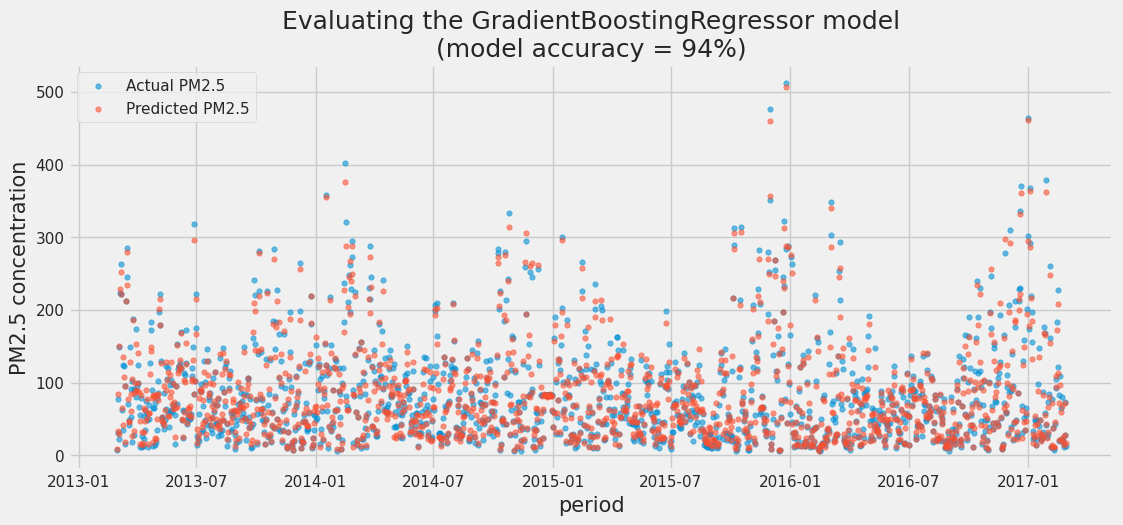

In [ ]:
# we now use the best model (GradientBoostingRegressor model) to predict the PM2.5
# concetration and compare it to the actual PM2.5 recorded in the data by means of
# visualization

compare_data = pd.DataFrame({'dates':data['date'],
                            'Actual PM2.5':y,
                            'Predicted PM2.5':gboost_search.predict(X.values)})

compare_data.set_index('dates',inplace=True)
compare_data['Predicted PM2.5'] = np.round(compare_data['Predicted PM2.5'],1)

# let's plot the daily averages of the Actual PM10 and the predicted PM2.5 concentration.
compare_data = compare_data.resample('D').mean()

with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(12,5))
    plt.scatter(compare_data.index,compare_data['Actual PM2.5'],s=15,label='Actual PM2.5',
               alpha=.6)
    plt.scatter(compare_data.index,compare_data['Predicted PM2.5'],s=15,label='Predicted PM2.5',
               alpha=.6)
    plt.legend()
    plt.title('Evaluating the GradientBoostingRegressor model\n(model accuracy = 94%)',
             fontsize=18)
    plt.xlabel('period',fontsize=15)
    plt.ylabel('PM2.5 concentration',fontsize=15)
    plt.show()

<h5><b>Residuals analysis</b></h5>
<p>Now that we have successfully trained a regression model that predicts the amount of PM2.5 concetration in the air with a 93% accuracy given other environmental features, we have to analyze the errors of prediction to see if the model satisfies the regression errors asumption. That is,the errors must be normally distributed and do not follow any pattern.</p>

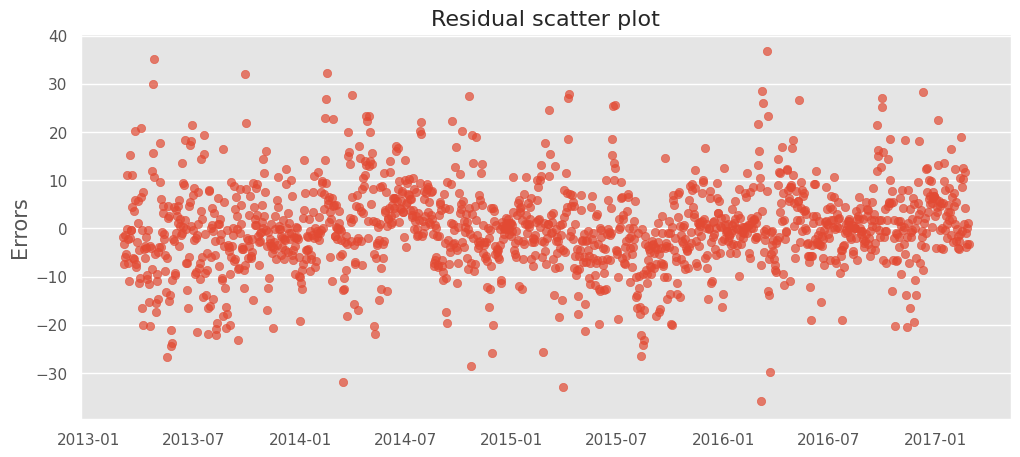

In [ ]:
# calculate the errors
compare_data['Residuals'] = compare_data['Actual PM2.5'] - compare_data['Predicted PM2.5']

# make a scatter plot of the errors to see if they follow any pattern
with plt.style.context('ggplot'):
    plt.figure(figsize=(12,5))
    plt.scatter(compare_data.index,compare_data.Residuals,alpha=.7)
    plt.title('Residual scatter plot',fontsize=16)
    plt.ylabel('Errors',fontsize=15)
    plt.grid(axis='x')
    plt.show()

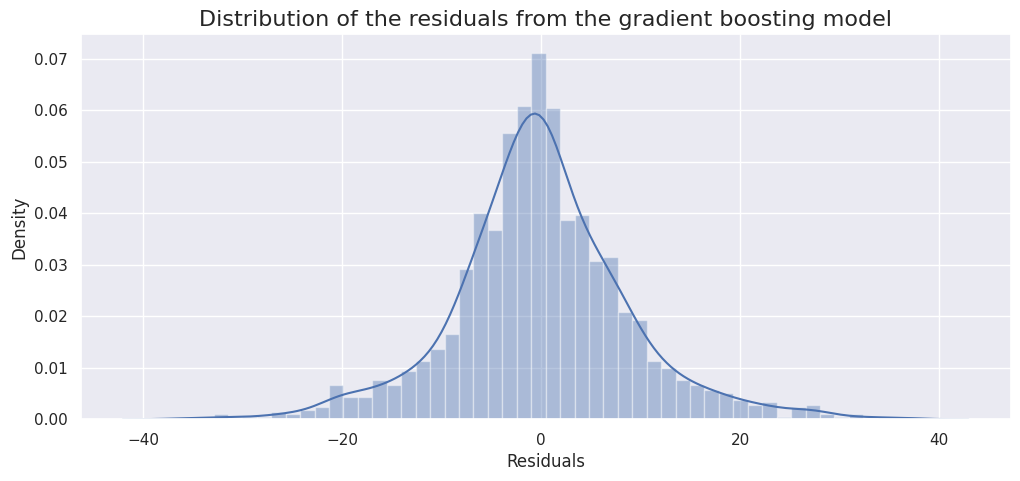

In [ ]:
# plot the histogram to see check the normality of the errors
plt.figure(figsize=(12,5))
sns.distplot(compare_data.Residuals,bins=50)
plt.title('Distribution of the residuals from the gradient boosting model',
         fontsize=16)
plt.show()

<p>As seen above, the residuals of the predictions follow no pattern and also have a normal distribution which satisfies the regression error assumptions. This proves that our model is accurate and good for further predictions.</p>
<br>


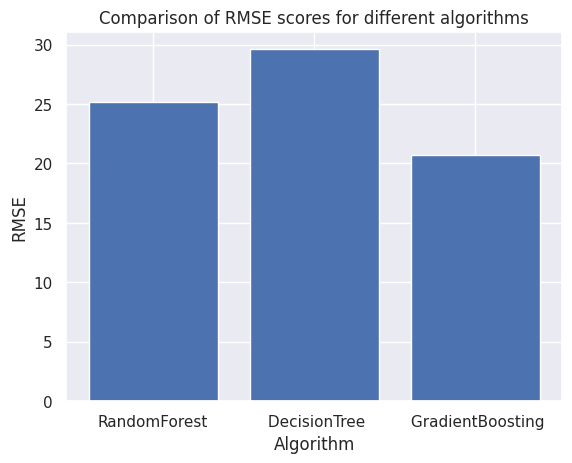

Root Mean Squared Error in RandomForest: 25.208003343861076

Root Mean Squared Error in DecisionTree: 29.604876747218654

Root Mean Squared Error in GradientBoosting: 20.70494888903837



In [ ]:
rmse_scores = {'RandomForest': np.sqrt(forest_mse), ' DecisionTree': np.sqrt(tree_mse), ' GradientBoosting': np.sqrt(gboost_mse)}


plt.bar(range(len(rmse_scores)), list(rmse_scores.values()), align='center')
plt.xticks(range(len(rmse_scores)), list(rmse_scores.keys()))
plt.xlabel('Algorithm')
plt.ylabel('RMSE')
plt.title('Comparison of RMSE scores for different algorithms')
plt.show()
print('Root Mean Squared Error in RandomForest: {}\n'.format(np.sqrt(forest_mse)))
print('Root Mean Squared Error in DecisionTree: {}\n'.format(np.sqrt(tree_mse)))
print('Root Mean Squared Error in GradientBoosting: {}\n'.format(np.sqrt(gboost_mse)))


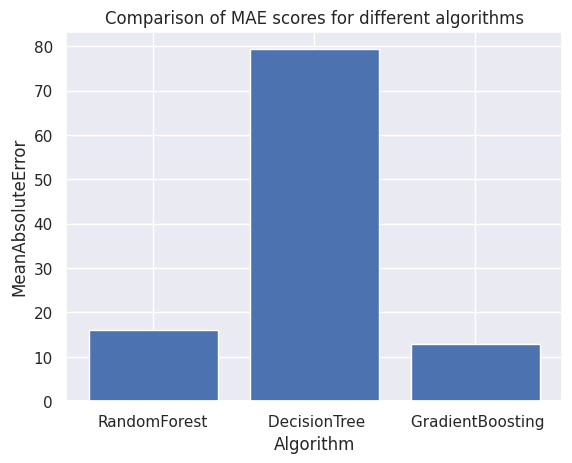

mean_absolute_error in RandomForest: 15.953052453174076
mean_absolute_error in DecisionTree: 79.29207917589699
mean_absolute_error in GradientBoosting: 12.992229518896622


In [ ]:
mae_scores = {'RandomForest':forest_mae , ' DecisionTree': tree_mae, ' GradientBoosting': gboost_mae}


plt.bar(range(len(mae_scores)), list(mae_scores.values()), align='center')
plt.xticks(range(len(mae_scores)), list(mae_scores.keys()))
plt.xlabel('Algorithm')
plt.ylabel('MeanAbsoluteError')
plt.title('Comparison of MAE scores for different algorithms')
plt.show()
print('mean_absolute_error in RandomForest: {}'.format(forest_mae))
print('mean_absolute_error in DecisionTree: {}'.format(tree_mae))
print('mean_absolute_error in GradientBoosting: {}'.format(gboost_mae))

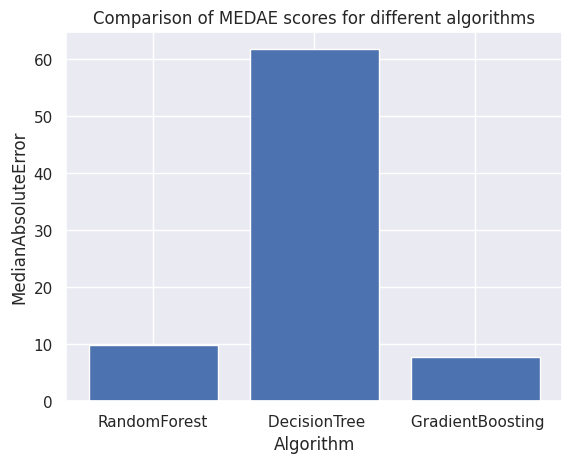

median_absolute_error in RandomForest: 9.928833537046614
median_absolute_error in DecisionTree: 61.75233801617325
median_absolute_error in GradientBoosting: 7.834887603868129


In [ ]:
medae_scores = {'RandomForest':forest_medae , ' DecisionTree': tree_medae, ' GradientBoosting': gboost_medae}


plt.bar(range(len(medae_scores)), list(medae_scores.values()), align='center')
plt.xticks(range(len(medae_scores)), list(medae_scores.keys()))
plt.xlabel('Algorithm')
plt.ylabel('MedianAbsoluteError')
plt.title('Comparison of MEDAE scores for different algorithms')
plt.show()
print('median_absolute_error in RandomForest: {}'.format(forest_medae))
print('median_absolute_error in DecisionTree: {}'.format(tree_medae))
print('median_absolute_error in GradientBoosting: {}'.format(gboost_medae))

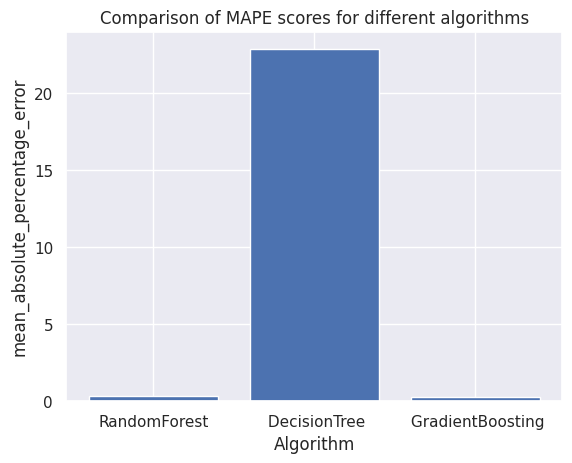

mean_absolute_percentage_error in RandomForest: 0.3320740794939839
mean_absolute_percentage_error in DecisionTree: 22.833107339850017
mean_absolute_percentage_error in GradientBoosting: 0.27281664087679397


In [ ]:
mape_scores = {'RandomForest':forest_mape , ' DecisionTree': tree_mape, ' GradientBoosting': gboost_mape}


plt.bar(range(len(mape_scores)), list(mape_scores.values()), align='center')
plt.xticks(range(len(mape_scores)), list(mape_scores.keys()))
plt.xlabel('Algorithm')
plt.ylabel('mean_absolute_percentage_error')
plt.title('Comparison of MAPE scores for different algorithms')
plt.show()
print('mean_absolute_percentage_error in RandomForest: {}'.format(forest_mape))
print('mean_absolute_percentage_error in DecisionTree: {}'.format(tree_mape))
print('mean_absolute_percentage_error in GradientBoosting: {}'.format(gboost_mape))

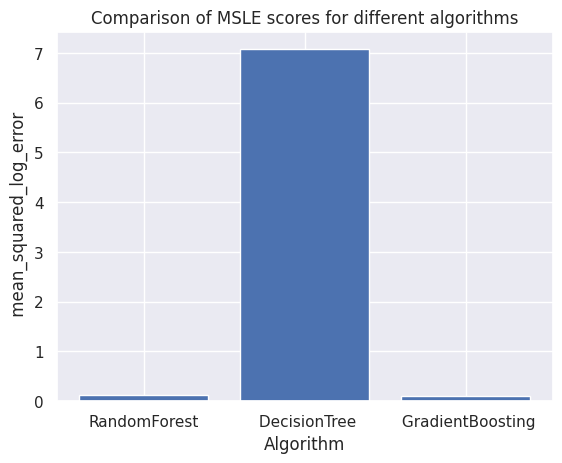

 mean_squared_log_error in RandomForest: 0.13563434415745668
 mean_squared_log_error in DecisionTree: 7.073289423009539
 mean_squared_log_error in GradientBoosting: 0.10491746424995008


In [ ]:
msle_scores = {'RandomForest':forest_msle , ' DecisionTree': tree_msle, ' GradientBoosting': gboost_msle}


plt.bar(range(len(msle_scores)), list(msle_scores.values()), align='center')
plt.xticks(range(len(msle_scores)), list(msle_scores.keys()))
plt.xlabel('Algorithm')
plt.ylabel(' mean_squared_log_error')
plt.title('Comparison of MSLE scores for different algorithms')
plt.show()
print(' mean_squared_log_error in RandomForest: {}'.format(forest_msle))
print(' mean_squared_log_error in DecisionTree: {}'.format(tree_msle))
print(' mean_squared_log_error in GradientBoosting: {}'.format(gboost_msle))

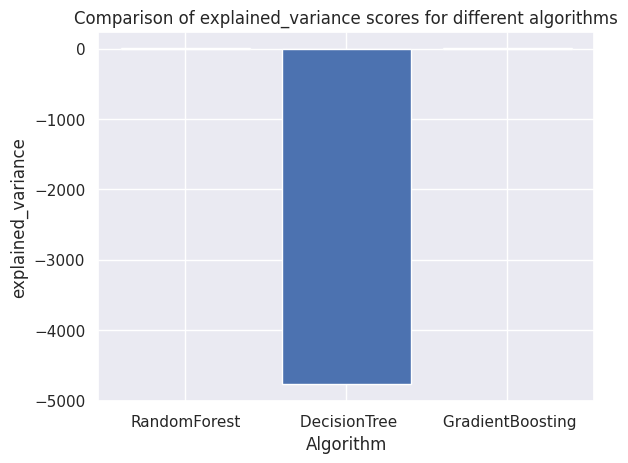

 mean_squared_log_error in RandomForest: 0.9017211007879722
 mean_squared_log_error in DecisionTree: -4770.906458079123
 mean_squared_log_error in GradientBoosting: 0.9336960240965441


In [ ]:

ev_scores = {'RandomForest':forest_ev , ' DecisionTree': tree_ev, ' GradientBoosting': gboost_ev}


plt.bar(range(len(ev_scores)), list(ev_scores.values()), align='center')
plt.xticks(range(len(ev_scores)), list(ev_scores.keys()))
plt.xlabel('Algorithm')
plt.ylabel('explained_variance')
plt.title('Comparison of explained_variance scores for different algorithms')
plt.show()
print(' mean_squared_log_error in RandomForest: {}'.format(forest_ev))
print(' mean_squared_log_error in DecisionTree: {}'.format(tree_ev))
print(' mean_squared_log_error in GradientBoosting: {}'.format(gboost_ev))

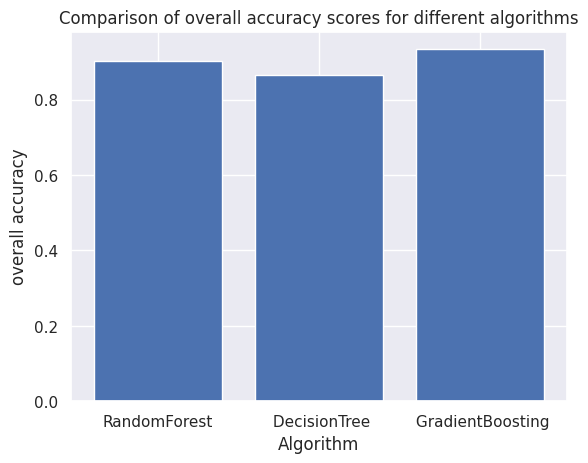

 mean_squared_log_error in RandomForest: 0.9017098356333795
 mean_squared_log_error in DecisionTree: 0.8644312222933069
 mean_squared_log_error in GradientBoosting: 0.9336896238772694


In [ ]:

accuracy_scores = {'RandomForest':forest_accuracy , ' DecisionTree': tree_accuracy, ' GradientBoosting': gboost_accuracy}


plt.bar(range(len(accuracy_scores)), list(accuracy_scores.values()), align='center')
plt.xticks(range(len(accuracy_scores)), list(accuracy_scores.keys()))
plt.xlabel('Algorithm')
plt.ylabel('overall accuracy')
plt.title('Comparison of overall accuracy scores for different algorithms')
plt.show()
print(' mean_squared_log_error in RandomForest: {}'.format(forest_accuracy))
print(' mean_squared_log_error in DecisionTree: {}'.format(tree_accuracy))
print(' mean_squared_log_error in GradientBoosting: {}'.format(gboost_accuracy))